# Internal Node System

The internal node model is modeled as:

\begin{align}
    \frac{\text{d} \delta_{i}}{\text{d} t} &= \omega_{i} - \omega_{s}  \label{eq: 15a}\\
%
    \frac{2H_{i}}{\omega_{s}} \frac{\text{d} \omega_{i}}{\text{d} t} &= T_{Mi} -  P_{ei} \label{eq: 15b} \\
%
    T_{CHi} \frac{\text{d} T_{Mi}}{\text{d} t} & = -T_{Mi} + P_{SVi} \label{eq: 15c} \\
    %
    T_{SVi}\frac{\text{d} P_{SVi}}{\text{d} t}  = -P_{SVi} + & P_{Ci} - \frac{1}{R_{Di}} \left(\frac{\omega_{i}}{\omega_{s}} - 1  \right) \label{eq: 15d} \\
    &  \quad \quad \quad \quad \forall i= 1, \ldots, m, \nonumber
\end{align}
where:
\begin{align}
  P_{Ci} & = P^0_{Ci} + k^{pf}_i Z
 \\
    P_{ei}  = E^2_iG_{ii} + & \sum^m_{j=1, j\neq i} (C_{ij}sin(\delta_{ij})+D_{ij}cos(\delta_{ij})) \label{eq: 14} \\
    \text{with} ~~~~~~ C_{ij} & = E_i E_j B_{ij}, D_{ij} = E_i E_j G_{ij}, \nonumber \\
    & \quad\quad\quad\quad\quad  \forall i = 1, \ldots, m. \nonumber
\end{align}

In [ ]:
using QuDiffEq                # package containt quantum computing' solvers.
using OrdinaryDiffEq          # package containt solvers to solve ODEs.
using ModelingToolkit         # package to convert DAEs to ODEs.
using DifferentialEquations   # package containt solvers to solve differential equations.
using Plots                   # package to plot the figure.
using LaTeXStrings            # oackage to type LaTex in the Julia

In [2]:
using CSV               #package to load and save CSV files.
using DataFrames        #package to create dataframe from array.
data = CSV.File("3gens.csv");

# The number of machine.
m = 3

# Y mamatrix for internal node.
# without changing loads
Y_init1 = CSV.read("Y_init_raw.CSV", DataFrame, types=Complex{Float64});

# changing loads
Y_init2 =CSV.read("Y_init_increasing_demand.CSV", DataFrame, types=Complex{Float64}); #Pl5 + 0.4, Pl8 + 0.3, Ql5 + 0.2im, and QL8 + 0.15im.
Y_init3 =CSV.read("Y_init_decreasing_demand.CSV", DataFrame, types=Complex{Float64}); #PL5 - 0.2, PL6 - 0.2, PL8 - 0.1, QL5 - 0.1im, QL6 - 0.05im, QL8 - 0.1im.

# magnitude voltage of machines.
E1 = 1.054;
E2 = 1.050;
E3 = 1.017;

In [3]:
@variables t (delta(t))[1:3] (omega(t))[1:3] (TM(t))[1:3] (Psv(t))[1:3] (Pc(t))[1:3] (Pe(t))[1:3] (x(t))[1:4]    # set of state variables
@parameters G11 G12 G13 G21 G22 G23 G31 G32 G33 B11 B12 B13 B21 B22 B23 B31 B32 B33 DL                            # parametees
D = Differential(t)                     # define the differential operator D by time t.
omega_s = round(120*pi, digits = 4)     # reference speed.

# define the ODEs of internal node model.
eq1 = [D(delta[1]) ~ omega[1] - omega_s,
    D(delta[2]) ~ omega[2] - omega_s,
    D(delta[3]) ~ omega[3] - omega_s,
    D(omega[1]) ~ (TM[1]-Pe[1])/(2*data["H"][1])*omega_s,
    D(omega[2]) ~ (TM[2]-Pe[2])/(2*data["H"][2])*omega_s,
    D(omega[3]) ~ (TM[3]-Pe[3])/(2*data["H"][3])*omega_s,
    0 ~ Pe[1] - (E1^2*G11 + E1*E2*sin(delta[1]-delta[2])*B12 + E1*E2*cos(delta[1]-delta[2])*G12 + E1*E3*sin(delta[1]-delta[3])*B13 + 
        E1*E3*cos(delta[1]-delta[3])*G13),
    0 ~ Pe[2] - (E2^2*G22 + E1*E2*sin(delta[2]-delta[1])*B21 + E1*E2*cos(delta[2]-delta[1])*G21 + E2*E3*sin(delta[2]-delta[3])*B23 + 
        E2*E3*cos(delta[2]-delta[3])*G23),
    0 ~ Pe[3] - (E3^2*G33 + E3*E1*sin(delta[3]-delta[1])*B31 + E3*E1*cos(delta[3]-delta[1])*G31 + E3*E2*sin(delta[3]-delta[2])*B32 + 
        E3*E2*cos(delta[3]-delta[2])*G32),
    ];

# define the differential equations of turbine and speed governor.
eq2 = [D(TM[i]) ~ (-TM[i]+Psv[i])/data["TCH"][i] for i in 1:3]
eq3 = [D(Psv[i]) ~ (-Psv[i]+Pc[i]-(omega[i]/omega_s -1)/data["RD"][i])/data["TSV"][i] for i in 1:3]

# power control for each situation.
# increase loads
eq4 = [0 ~ Pc[1] - 0.70945 + 0.63*(DL),
    0 ~ Pc[2] - 1.62342 + 0.235*(DL),
    0 ~ Pc[3] - 0.84843 + 0.135*(DL)]


# decrease loads
eq5 = [0 ~ Pc[1] - 0.70945 + 0.34*(DL),
    0 ~ Pc[2] - 1.62342 + 0.33*(DL),
    0 ~ Pc[3] - 0.84843 + 0.33*(DL)]

# add the extra variable to form the logarithmic of the variables.
eq6 = [D(x[i]) ~ 0 for i in 1:4]

# combine equations to get the fill model of each situation.
# icrease loads
eqs = [eq1; eq2; eq3; eq4; eq6];

# decrease loads
eqs1 = [eq1; eq2; eq3; eq5; eq6];

In [4]:
# simulation duration.
# first period
tspan1 = (0.0,5.0)

# second period
tspan2 = (0.0,30.0)

# initial conditions
u1 = [delta[1] => 0.03957, delta[2] => 0.3447, delta[3] => 0.23038]
#
u2 = [omega[i] => 120*pi for i in 1:3]
#
u3 = [Pe[1] => 0.70945,Pe[2] => 1.62342, Pe[3] => 0.848433]
#
u4 = [TM[1] => 0.70945,TM[2] => 1.62342, TM[3] => 0.848433]
#
u5 = [Psv[1] => 0.70945,Psv[2] => 1.62342, Psv[3] => 0.848433]
#
u6 = [Pc[1] => 0.70945,Pc[2] => 1.62342, Pc[3] => 0.848433, x =>0]
#
u7 = [x[i] => 0 for i in 1:4]
#
u0 = [u1;u2;u3;u4;u5;u6;u7]

# define parameters of iternal node model corresponding with each situation.
# withput changing loads
p1 = [G11 => Y_init1[1,1].re, G12 => Y_init1[1,2].re, G13 => Y_init1[1,3].re, G21 => Y_init1[2,1].re, G22 => Y_init1[2,2].re, G23 => Y_init1[2,3].re,
    G31 => Y_init1[3,1].re, G32 => Y_init1[3,2].re, G33 => Y_init1[3,3].re, B11 => Y_init1[1,1].im, B12 => Y_init1[1,2].im, B13 => Y_init1[1,3].im,
    B21 => Y_init1[2,1].im, B22 => Y_init1[2,2].im, B23 => Y_init1[2,3].im, B31 => Y_init1[3,1].im, B32 => Y_init1[3,2].im, B33 => Y_init1[3,3].im, DL => 0]

# increase loads
p2 = [G11 => Y_init2[1,1].re, G12 => Y_init2[1,2].re, G13 => Y_init2[1,3].re, G21 => Y_init2[2,1].re, G22 => Y_init2[2,2].re, G23 => Y_init2[2,3].re,
    G31 => Y_init2[3,1].re, G32 => Y_init2[3,2].re, G33 => Y_init2[3,3].re, B11 => Y_init2[1,1].im, B12 => Y_init2[1,2].im, B13 => Y_init2[1,3].im,
    B21 => Y_init2[2,1].im, B22 => Y_init2[2,2].im, B23 => Y_init2[2,3].im, B31 => Y_init2[3,1].im, B32 => Y_init2[3,2].im, B33 => Y_init2[3,3].im, DL => -0.42];

# decrease loads
p3 = [G11 => Y_init3[1,1].re, G12 => Y_init3[1,2].re, G13 => Y_init3[1,3].re, G21 => Y_init3[2,1].re, G22 => Y_init3[2,2].re, G23 => Y_init3[2,3].re,
    G31 => Y_init3[3,1].re, G32 => Y_init3[3,2].re, G33 => Y_init3[3,3].re, B11 => Y_init3[1,1].im, B12 => Y_init3[1,2].im, B13 => Y_init3[1,3].im,
    B21 => Y_init3[2,1].im, B22 => Y_init3[2,2].im, B23 => Y_init3[2,3].im, B31 => Y_init3[3,1].im, B32 => Y_init3[3,2].im, B33 => Y_init3[3,3].im, DL => +0.34];

## Increase loads

#### Quantum LDE

In [5]:
#Create ODEs system from the equations.
@named three_machine = ODESystem(eqs)
three_machine_simp = structural_simplify(three_machine)
prob1 = ODEProblem(three_machine_simp,u0,tspan1,p1);

# the k_th order of Taylor expansion
k = 5
# solve the first period.
qsol1 = solve(prob1,QuLDE(k),dt = 0.01, adaptive = false);
u02 = qsol1[end,:]

# solve the second period.
prob2 = ODEProblem(three_machine_simp,u02,tspan2,p2);
qsol2 = solve(prob2,QuLDE(k),dt = 0.01, adaptive = false);

#### Runge-Kutta

In [6]:
# solve the first period.
prob1 = ODEProblem(three_machine_simp,u0,tspan1,p1);
sol1 = solve(prob1,Tsit5(),dt = 0.01, adaptive = false);
u02 = sol1.u[end]

# solve the second period.
prob2 = ODEProblem(three_machine_simp,u02,tspan2,p2);
sol2 = solve(prob2,Tsit5(),dt = 0.01, adaptive = false);

#### Plot the results.

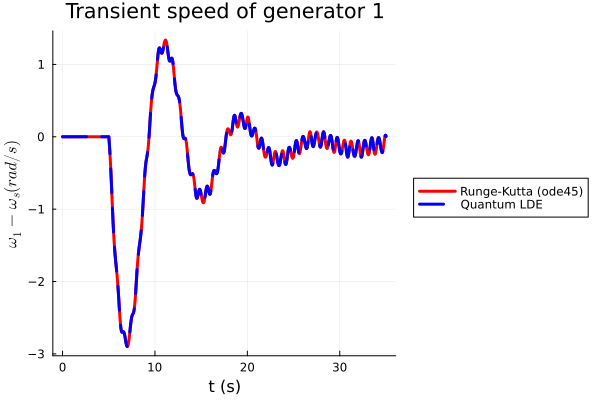

In [7]:
time_array = 0.0:0.01:35.01
p = plot(time_array, [sol1[4,:] .- omega_s; sol2[4,:] .- omega_s], title = "Transient speed of generator 1", label = "Runge-Kutta (ode45)", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1[:,4] .- omega_s; qsol2[:,4] .- omega_s], label = "Quantum LDE", lc = :blue, ls = :dash, lw = 3)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!(L"\omega_1 - \omega_s (rad/s)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

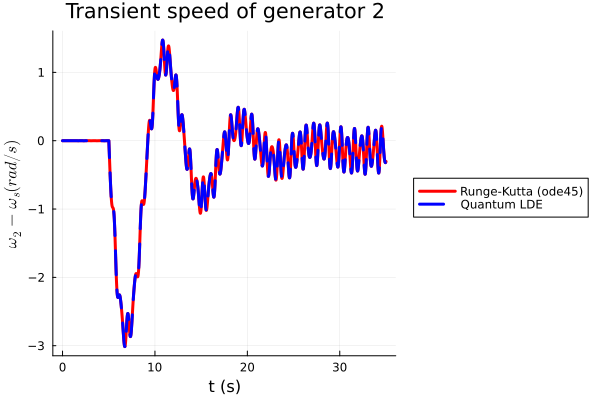

In [8]:
p = plot(time_array, [sol1[5,:] .- omega_s; sol2[5,:] .- omega_s], title = "Transient speed of generator 2", label = "Runge-Kutta (ode45)", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1[:,5] .- omega_s ; qsol2[:,5] .- omega_s], label = "Quantum LDE", lc = :blue, ls = :dash, lw = 3)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!(L"\omega_2 - \omega_s (rad/s)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

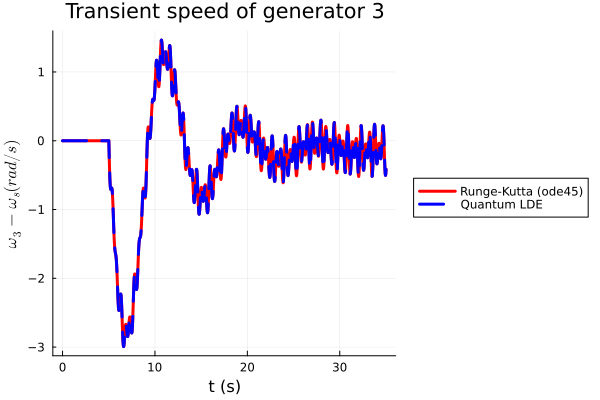

In [9]:
p = plot(time_array, [sol1[6,:] .- omega_s; sol2[6,:] .- omega_s], title = "Transient speed of generator 3", label = "Runge-Kutta (ode45)", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1[:,6] .- omega_s; qsol2[:,6] .- omega_s], label = "Quantum LDE", lc = :blue, ls = :dash, lw = 3)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!(L"\omega_3 - \omega_s (rad/s)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

#### Save the results.

In [ ]:
header = ["delta1","delta2","delta3","omega1","omega2","omega3","","","","","","","","x1","x2","x3"];
using CSV
open("results/internal/ODE_I_5.csv", "w") do f
    CSV.write(f,[], writeheader=true, header = header)
end
open("results/internal/Quan_I_5.csv", "w") do f
    CSV.write(f,[], writeheader=true, header = header)
end
df_qsol1 = DataFrame(qsol1, :auto)
df_qsol2 = DataFrame(qsol2, :auto)
CSV.write("results/internal/Quan_I_5.csv", df_qsol1,append = true)
CSV.write("results/internal/Quan_I_5.csv", df_qsol2,append = true)
sol1 = transpose(sol1)
sol2 = transpose(sol2)
df_sol1 = DataFrame(sol1, :auto)
df_sol2 = DataFrame(sol2, :auto)
CSV.write("results/internal/ODE_I_5.csv", df_sol1,append = true)
CSV.write("results/internal/ODE_I_5.csv", df_sol2,append = true)

## Decrease Loads

#### quantum LDE

In [10]:
@named three_machine1 = ODESystem(eqs1)
three_machine_simp1 = structural_simplify(three_machine1)
prob1 = ODEProblem(three_machine_simp1,u0,tspan1,p1);
k = 5
qsol1 = solve(prob1,QuLDE(k),dt = 0.01, adaptive = false);
u02 = qsol1[end,:]
prob2 = ODEProblem(three_machine_simp1,u02,tspan2,p3);
qsol2 = solve(prob2,QuLDE(k),dt = 0.01, adaptive = false);

#### Runge-Kutta

In [12]:
prob1 = ODEProblem(three_machine_simp1,u0,tspan1,p1);
sol1 = solve(prob1,Tsit5(),dt = 0.01, adaptive = false);
u02 = sol1.u[end]
prob2 = ODEProblem(three_machine_simp1,u02,tspan2,p3);
sol2 = solve(prob2,Tsit5(),dt = 0.01, adaptive = false);

#### Plot the results.

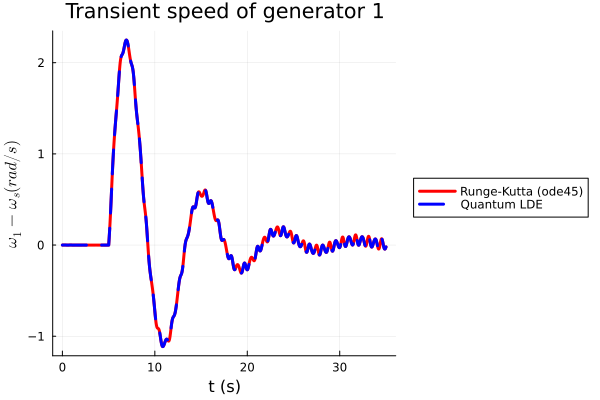

In [13]:
time_array = 0.0:0.01:35.01
p = plot(time_array, [sol1[4,:] .- omega_s; sol2[4,:] .- omega_s], title = "Transient speed of generator 1", label = "Runge-Kutta (ode45)", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1[:,4] .- omega_s; qsol2[:,4] .- omega_s], label = "Quantum LDE", lc = :blue, ls = :dash, lw = 3)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!(L"\omega_1 - \omega_s (rad/s)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

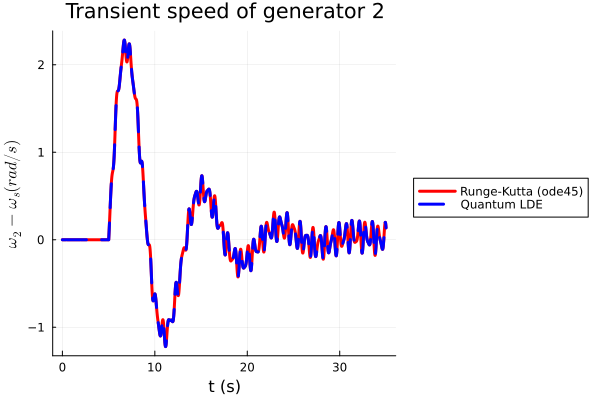

In [14]:
p = plot(time_array, [sol1[5,:] .- omega_s; sol2[5,:] .- omega_s], title = "Transient speed of generator 2", label = "Runge-Kutta (ode45)", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1[:,5] .- omega_s; qsol2[:,5] .- omega_s], label = "Quantum LDE", lc = :blue, ls = :dash, lw = 3)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!(L"\omega_2 - \omega_s (rad/s)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

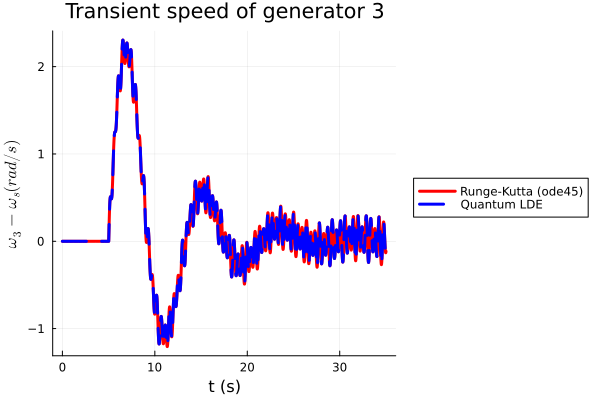

In [18]:
p = plot(time_array, [sol1[6,:] .- omega_s; sol2[6,:] .- omega_s], title = "Transient speed of generator 3", label = "Runge-Kutta (ode45)", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1[:,6] .- omega_s; qsol2[:,6] .- omega_s], label = "Quantum LDE", lc = :blue, ls = :dash, lw = 3)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!(L"\omega_3 - \omega_s (rad/s)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

#### Save the results.

In [ ]:
header = ["delta1","delta2","delta3","omega1","omega2","omega3","","","","","","","","x1","x2","x3"];
using CSV
open("results/internal/ODE_D_5.csv", "w") do f
    CSV.write(f,[], writeheader=true, header = header)
end
open("results/internal/Quan_D_5.csv", "w") do f
    CSV.write(f,[], writeheader=true, header = header)
end
df_qsol1 = DataFrame(qsol1, :auto)
df_qsol2 = DataFrame(qsol2, :auto)
CSV.write("results/internal/Quan_D_5.csv", df_qsol1,append = true)
CSV.write("results/internal/Quan_D_5.csv", df_qsol2,append = true)
sol1 = transpose(sol1)
sol2 = transpose(sol2)
df_sol1 = DataFrame(sol1, :auto)
df_sol2 = DataFrame(sol2, :auto)
CSV.write("results/internal/ODE_D_5.csv", df_sol1,append = true)
CSV.write("results/internal/ODE_D_5.csv", df_sol2,append = true);